[PSSE05](https://www.kaggle.com/competitions/playground-series-s4e5)

**Contents**

This notebook explains a way to cross validate an ensemble for a regression, by using **Ridge**. **LinearRegressor** also works, but a little bit worse for our data.

First, I trained a variety of models outside this notebook and store in csv files 3 oof files for each, and 3 prediction files for each (RepeatedStratifiedKfold) : I store few of those csv files in a Kaggle dataset to use them in this notebook for my final submission.

Second, I've repeated Ridge regression by CV of various combinations of oofs predictions to find the best combination. To do that, I studied regression coefficients over folds, and feature importance by permutation of values :
* **permutation of values** helped me to detect useless models in my Ridge model
* **unstable coefficents** (>0 in some folds, <0 in some others etc.) helped me too.
* when I saw that two models have the same coefficient, and because linear Regression likes **parsimony**, I grouped those models in a meta one to fit only one coefficient instead of two

I've compared validation score for each folds, to the max score of individual models, and to the mean of individual models. By this way I was sure that Ridge did always better than the best individual models or the mean of my models.

That's all.

# Libraries & data

In [7]:
n_repeats, n_splits, seed = 3, 5, 1984
target = "FloodProbability"
path, oofs_path = "data/", "data/"    # when I work on my own PC

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
def score_(y_trn, y_pred):
    return r2_score(y_trn, y_pred)

from sklearn.linear_model import Ridge

In [8]:
end = "\033[0m" # reset

bold       = "\033[1m" ; resetbold       = "\033[21m"
underline  = "\033[4m" ; resetunderline  = "\033[24m"
blink      = "\033[5m" ; resetblink      = "\033[25m"
reverse    = "\033[7m" ; resetreverse    = "\033[27m"

Default      = "\033[39m" ; Black        = "\033[30m" ; White        = "\033[97m"
Red          = "\033[31m" ; LightRed     = "\033[91m"
Green        = "\033[32m" ; LightGreen   = "\033[92m"
Yellow       = "\033[33m" ; LightYellow  = "\033[93m"
Blue         = "\033[34m" ; LightBlue    = "\033[94m"
Magenta      = "\033[35m" ; LightMagenta = "\033[95m"
Cyan         = "\033[36m" ; LightCyan    = "\033[96m"
DarkGray     = "\033[90m" ; LightGray    = "\033[37m"

BackgroundDefault     = "\033[49m"  ; BackgroundBlack        = "\033[40m"
BackgroundRed         = "\033[41m"  ; BackgroundLightRed     = "\033[101m"
BackgroundGreen       = "\033[42m"  ; BackgroundLightGreen   = "\033[102m"
BackgroundYellow      = "\033[43m"  ; BackgroundLightYellow  = "\033[103m"
BackgroundBlue        = "\033[44m"  ; BackgroundLightBlue    = "\033[104m"
BackgroundMagenta     = "\033[45m"  ; BackgroundLightMagenta = "\033[105m"
BackgroundCyan        = "\033[46m"  ; BackgroundLightCyan    = "\033[106m"
BackgroundDarkGray    = "\033[100m" ; BackgroundLightGray    = "\033[47m"

bold_blue = bold + LightBlue

In [9]:
train = pd.read_csv(f'{path}/train.csv', index_col = "id")
test = pd.read_csv(f'{path}/test.csv', index_col = "id")

# Oofs & preds files

In [10]:
models = [f"xgb{i}" for i in [8, 10, 11, 12, 13]] + [f"lgbm{i}" for i in [5, 9, 16]] + [
    f"cb{i}" for i in [2, 3, 7, 9, 12, 13]] + ["bestlgbmcorr"] + [f"autog{i}" for i in [3, 5]]

oofs, preds = [], []
for r in range(n_repeats):
    
    for i, m in enumerate(models):
        
        if i == 0:
            oofs.append(pd.read_csv(f"{oofs_path}oof_{m}_r{r+1}.csv", index_col = "id").rename(columns = {target:m}))
            preds.append(pd.read_csv(f"{oofs_path}pred_{m}_r{r+1}.csv", index_col = "id").rename(columns = {target:m}))
        else:
            oofs[r] = pd.concat([oofs[r], pd.read_csv(f"{oofs_path}oof_{m}_r{r+1}.csv", index_col = "id").rename(columns = {target:m})], axis = 1)        
            preds[r] = pd.concat([preds[r], pd.read_csv(f"{oofs_path}pred_{m}_r{r+1}.csv", index_col = "id").rename(columns = {target:m})], axis = 1)        

    oofs[r] = oofs[r]
    oofs[r][target] = train[target]
    preds[r] = preds[r]

FileNotFoundError: [Errno 2] No such file or directory: 'data/oof_xgb8_r1.csv'

In [11]:
all_scores = {}
ascending = True
for r in range(n_repeats):
    for m in [f for f in oofs[r].columns if f not in [target]]:
        if r == 0:
            all_scores[m] = []
        all_scores[m].append(score_(train[target], oofs[r][m]))
        
all_scores = pd.DataFrame(all_scores)
_col_order = list(all_scores.mean(axis=0).sort_values(ascending = ascending).index)
all_scores = all_scores[_col_order]

_t = list(all_scores.mean(axis=0).sort_values(ascending = ascending).values)
_labels = [f"{l:15} ({v:.5})" for l,v in zip(_col_order, _t)]

_, ax = plt.subplots(1, 1, figsize = (10, int(all_scores.shape[1] * 1/2)))
ax.boxplot(all_scores, vert = False, labels = _labels)
ax.set_title("OOFS R2")
ax.set_xlabel("R2 (higher is better)")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position('top')
ax.spines[["right", "bottom"]].set_visible(False)

IndexError: list index out of range

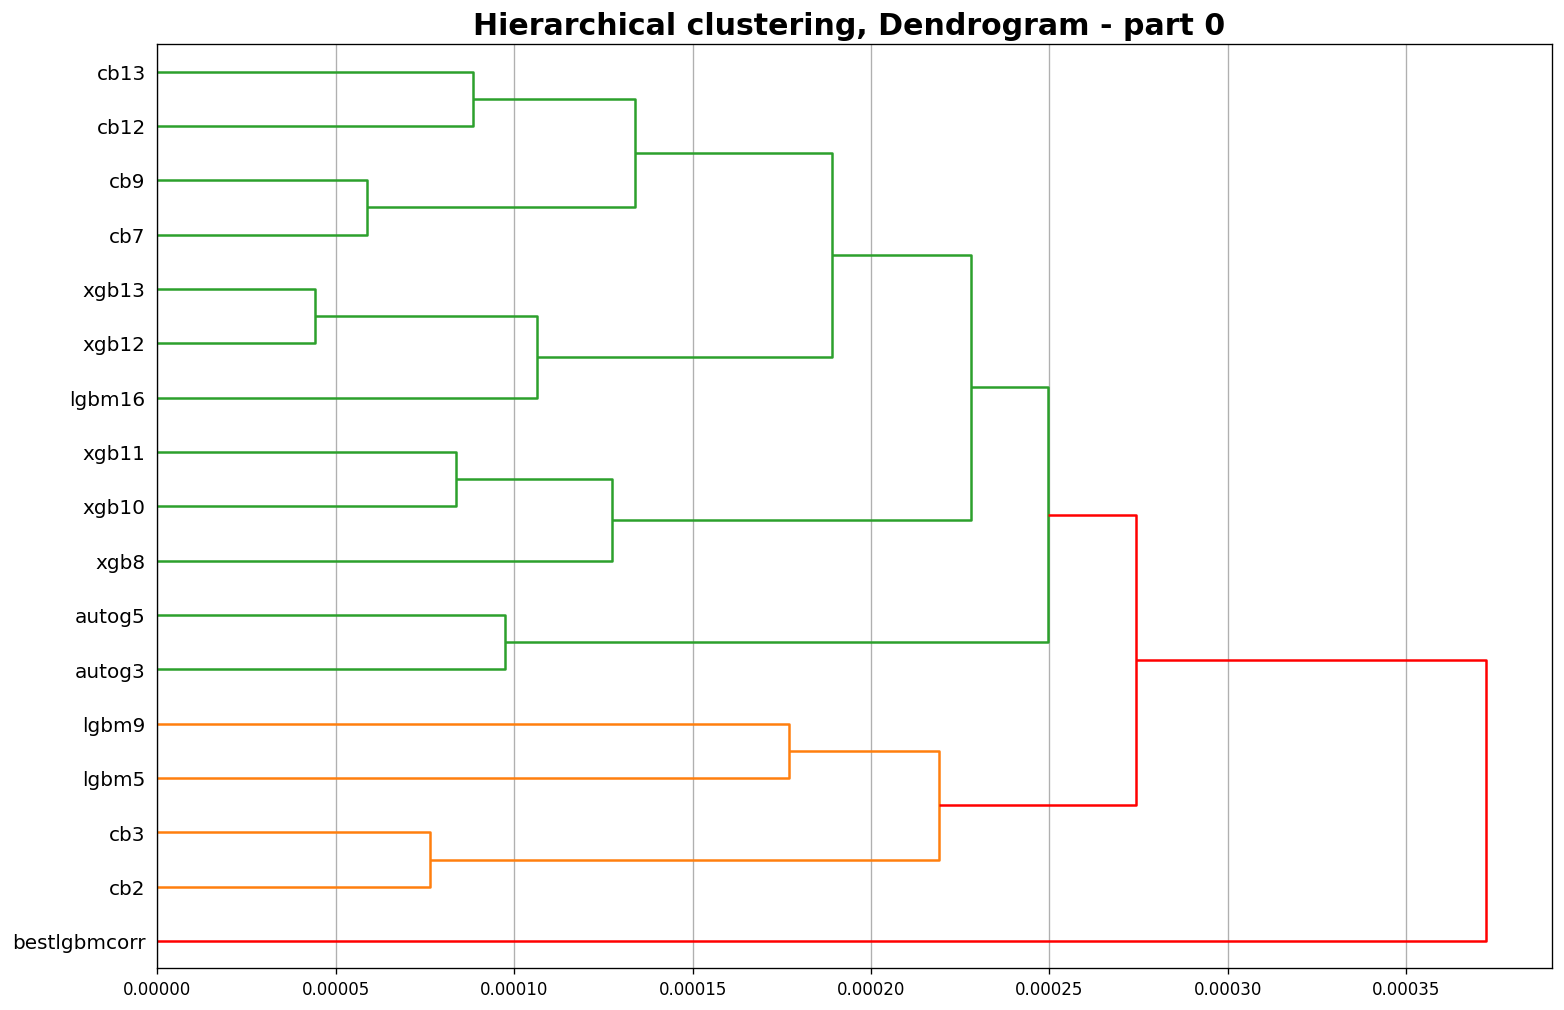

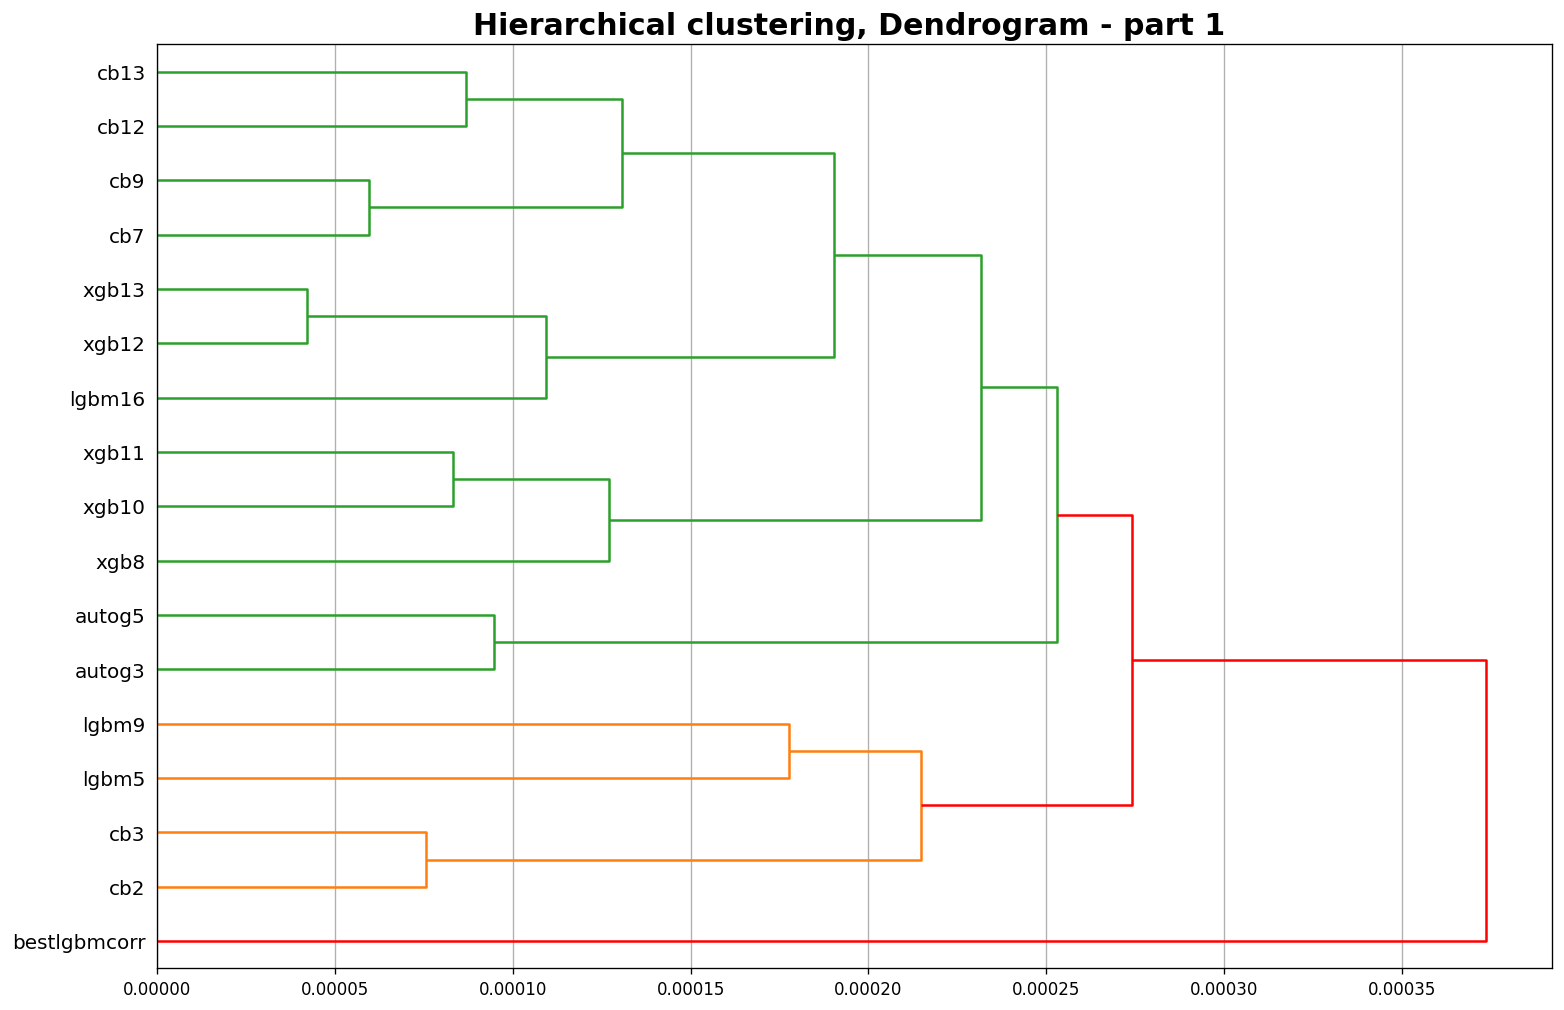

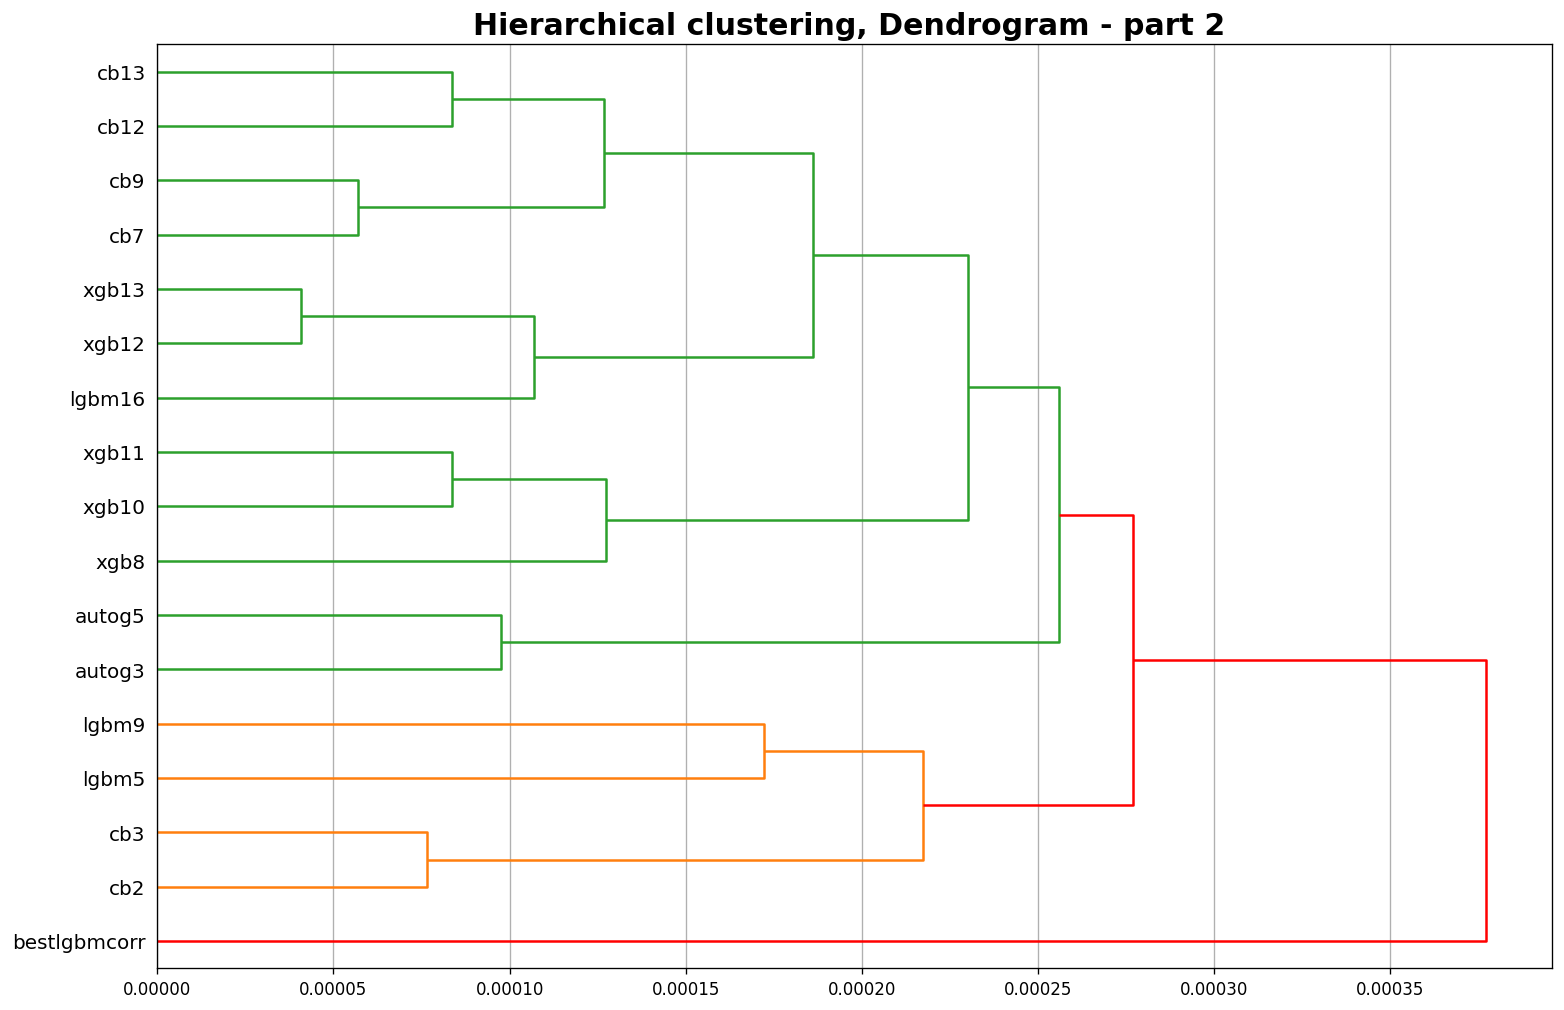

In [6]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

def hierarchical_clustering(data, title):
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=120)
    correlations = data.corr()
    converted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(converted_corr), 'complete')
    
    dn = dendrogram(Z, labels = data.columns, ax = ax, above_threshold_color = '#ff0000', orientation = 'right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'Hierarchical clustering, Dendrogram - part {title} ', fontsize=18, fontweight='bold')
    plt.show()
    
for i in range(n_repeats):
    hierarchical_clustering(oofs[i][models], title = f"{i}")

# Functions
## Feature importance

In [7]:
class FeatureImportance():
    
    def __init__(self, n_permutations = None, lib_metric = None, digit = 4):
        
        self.n_permutations = n_permutations
        self.lib_metric = lib_metric
        self.differences = {}
        self.digit = digit
        
        self.metric_max = ["Accuracy", "AUC", "Recall@20", "cohen_kappa_score", "auc", "f1", "R2"]
        self.metric_min = ["Logloss", "rmse", "RMSE", "mae", "Balanced log loss", "RMSLE"]
        if lib_metric not in self.metric_max + self.metric_min:
            raise ValueError(f"Unknown lib_metric : {lib_metric}.")
        
    def append(self, feature, metric_value, metric_ref):
        
        if feature not in self.differences.keys():
            self.differences[feature] = []
            
        self.differences[feature].append(metric_value - metric_ref)
        
    def build_dataframe(self):
        
        if self.differences == {}: return
        
        df_diff = pd.DataFrame(self.differences).transpose()
        df_diff["mean"] = df_diff.mean(axis=1)
        df_diff.sort_values("mean", ascending = self.lib_metric in self.metric_max, inplace=True)
        
        return df_diff
        
    def plot(self, title=""):
        
        if self.differences == {}: return
        
        df_diff = self.build_dataframe()
        
        fk = next(iter(self.differences))
        len_fk = len(self.differences[fk])
        
        fig, ax = plt.subplots(1, 2, figsize = (15, int(df_diff.shape[0] * 1/2)))
            
        ax[0].boxplot(df_diff[[c for c in range(len_fk)]][::-1].T,
                          vert=False, labels=df_diff.index[::-1])
        ax[0].axvline(x = 0, color = 'green')
        ax[0].set_xlabel(f"Distribution {self.lib_metric} difference after permutation of values")
            
        sns.barplot(x = "mean", y = df_diff.index, data = df_diff, ax = ax[1], color = "green")
        ax[1].bar_label(ax[1].containers[0], fmt = f'%.{self.digit}f', padding = 2)
        ax[1].set_xlabel(f"Mean {self.lib_metric} difference after permutation of values")
        ax[1].set_yticklabels([])
        ax[1].set_yticks([])
        
        for ax_ in ax:
            ax_.set_title(title)
            ax_.xaxis.set_ticks_position("top")
            ax_.xaxis.set_label_position('top')
            ax_.spines[["right", "bottom"]].set_visible(False)
        ax[1].spines[["left"]].set_visible(False)

## CV ensemble loop

In [8]:
def do_ensemble(train = train, target = target, features = test.columns, test = test, 
                folds = StratifiedKFold(n_splits = n_splits, random_state = seed, shuffle = True), 
                my_model = None, digit = 6, lib_metric = "R2", do_feat_imp = False):
    
    feat_imp = FeatureImportance(n_permutations = 2, lib_metric = lib_metric)
    val_scores, trn_scores = [], []
    oofs = pd.Series(0.0, name = target, index = train.index)
    preds = pd.Series(0.0, name = target, index = test.index)
    intercept, coefs = [], pd.DataFrame(0.0, index = features, columns = [f"fold{i+1}" for i in range(folds.get_n_splits())])
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(train, (train[target]*400).astype(np.int16).astype("category"))):
        
        X_trn, y_trn = train.loc[trn_idx, features], train.loc[trn_idx, target]
        X_val, y_val = train.loc[val_idx, features], train.loc[val_idx, target]
            
        if (fold) % n_splits == 0:
            oof = pd.Series(0.0, name = target, index = train.index)
            pred = pd.Series(0.0, name = target, index = test.index)
        
        # Training
        my_model.fit(X_trn, y_trn)
        intercept.append(my_model.intercept_) ; coefs[f"fold{fold+1}"] += my_model.coef_

        # Score & prediction
        trn_scores.append(score_(y_trn, my_model.predict(X_trn)))
        oof.iloc[val_idx] += my_model.predict(X_val)
        val_scores.append(score_(y_val, oof.loc[val_idx]))
        oofs.iloc[val_idx] += oof.loc[val_idx]
        pred += my_model.predict(test[features]) / folds.get_n_splits()
            
        scores = []
        for f in features:
            scores.append(score_(y_val, X_val[f]))
        
        my_color = Green if np.max(scores) < val_scores[-1:][0] else LightRed
        print(f"    Fold {fold + 1:2} : {lib_metric} {val_scores[-1:][0]:.{digit}f} (max : {my_color}{np.max(scores):.{digit}f}{end} - ", end='')
        my_color = Green if score_(y_val, X_val[features].mean(axis = 1)) < val_scores[-1:][0] else LightRed
        print(f"mean : {my_color}{np.mean(scores):.{digit}f}{end})", end='')        
        print(f" | in train {trn_scores[-1:][0]:.{digit}f}", end='')
        print(f' | Overfitting {trn_scores[-1:][0] - val_scores[-1:][0]:.{digit}f}')
        if (fold + 1) % n_splits == 0:
            print(f'  {bold}Repeat {(fold + 1 ) // n_splits:2} : OOF {lib_metric} {bold_blue}{score_(train[target], oof):.{digit}f}{end} | ', end='')
            print(f'Mean {lib_metric} {np.mean(val_scores[-n_splits:]):.{digit}f}')
            preds += pred
        
        # Feature importance
        if do_feat_imp:
            for feat in features:
                for i in range(feat_imp.n_permutations):
                    df = X_val.copy()
                    df[feat] = pd.Series(np.random.permutation(df[feat]), index=df.index).astype(X_val[feat].dtypes)
                    feat_imp.append(feat, score_(y_val, my_model.predict(df)), val_scores[-1:][0])
    # end of loop
    
    scores = []
    for f in features:
        scores.append(score_(train[target], train[f]))
    print(f'OOF {lib_metric} {bold_blue}{score_(train[target], oofs):.{digit}f}{end}', end='')
    my_color = Green if np.max(scores) < score_(train[target], oofs) else LightRed
    print(f' (max was {my_color}{np.max(scores):.{digit}f}{end} - ', end='')
    my_color = Green if np.mean(scores) < score_(train[target], oofs) else LightRed
    print(f'mean {my_color}{np.mean(scores):.{digit}f}{end}) | ', end='')
    print(f'Mean {lib_metric} : {bold_blue}{np.mean(val_scores):.{digit}f}{end}({bold+Red}±{np.std(val_scores):.{digit}f}){end}) | ', end='')
    print(f'Overfitting : {np.mean(trn_scores)-np.mean(val_scores):.{digit}f}')
    
    feat_imp.plot()
    
    return {"intercept":intercept, "coefs":coefs.transpose(), "oofs_score":score_(train[target], oofs), "oofs":oofs, "preds":preds}

# Ensemble without AutoGluon predictions
## Benchmark : all oofs files except those obtained with autogluon

In [9]:
final_models = [ m for m in models if m not in ["autog3", "autog5"]]

params = {"alpha": .01, "random_state": seed, "fit_intercept" : False}

all_intercepts, all_coefs, blend_scores = [], [], []

for r in range(n_repeats):
    new_model = {
        "train"       : oofs[r], 
        "test"        : preds[r], 
        "features"    : final_models,
        "my_model"    : Ridge(**params), 
    }
    res = do_ensemble(**new_model, do_feat_imp = False)
    all_intercepts.extend(res["intercept"]) ; all_coefs.append(res["coefs"])
    blend_scores.append(res["oofs_score"])
    
print(f"{bold}Final mean RMSE {bold_blue}{np.mean(blend_scores):.6f}{end}")

    Fold  1 : R2 0.869615 (max : 0.869529 - mean : 0.869396) | in train 0.869520 | Overfitting -0.000094
    Fold  2 : R2 0.869765 (max : 0.869658 - mean : 0.869545) | in train 0.869483 | Overfitting -0.000281
    Fold  3 : R2 0.869564 (max : 0.869491 - mean : 0.869348) | in train 0.869533 | Overfitting -0.000031
    Fold  4 : R2 0.869473 (max : 0.869351 - mean : 0.869247) | in train 0.869556 | Overfitting 0.000083
    Fold  5 : R2 0.869244 (max : 0.869144 - mean : 0.869025) | in train 0.869613 | Overfitting 0.000369
  Repeat  1 : OOF R2 0.869532 | Mean R2 0.869532
OOF R2 0.869532 (max was 0.869417 - mean 0.869312) | Mean R2 : 0.869532(±0.000172)) | Overfitting : 0.000009
    Fold  1 : R2 0.869599 (max : 0.869518 - mean : 0.869390) | in train 0.869511 | Overfitting -0.000087
    Fold  2 : R2 0.869759 (max : 0.869664 - mean : 0.869555) | in train 0.869472 | Overfitting -0.000287
    Fold  3 : R2 0.869552 (max : 0.869499 - mean : 0.869340) | in train 0.869522 | Overfitting -0.000030
    

Let's read the first line : 0.869656 is the validation score. This score is higher than the max of individuals models (.86956) and than the mean of individual models (.869441). We are .0001 better than max, and .0002 better then mean.  
Ridge is better than best individual model and better than mean ! 15 times on 15.

Let's study coefficients : 

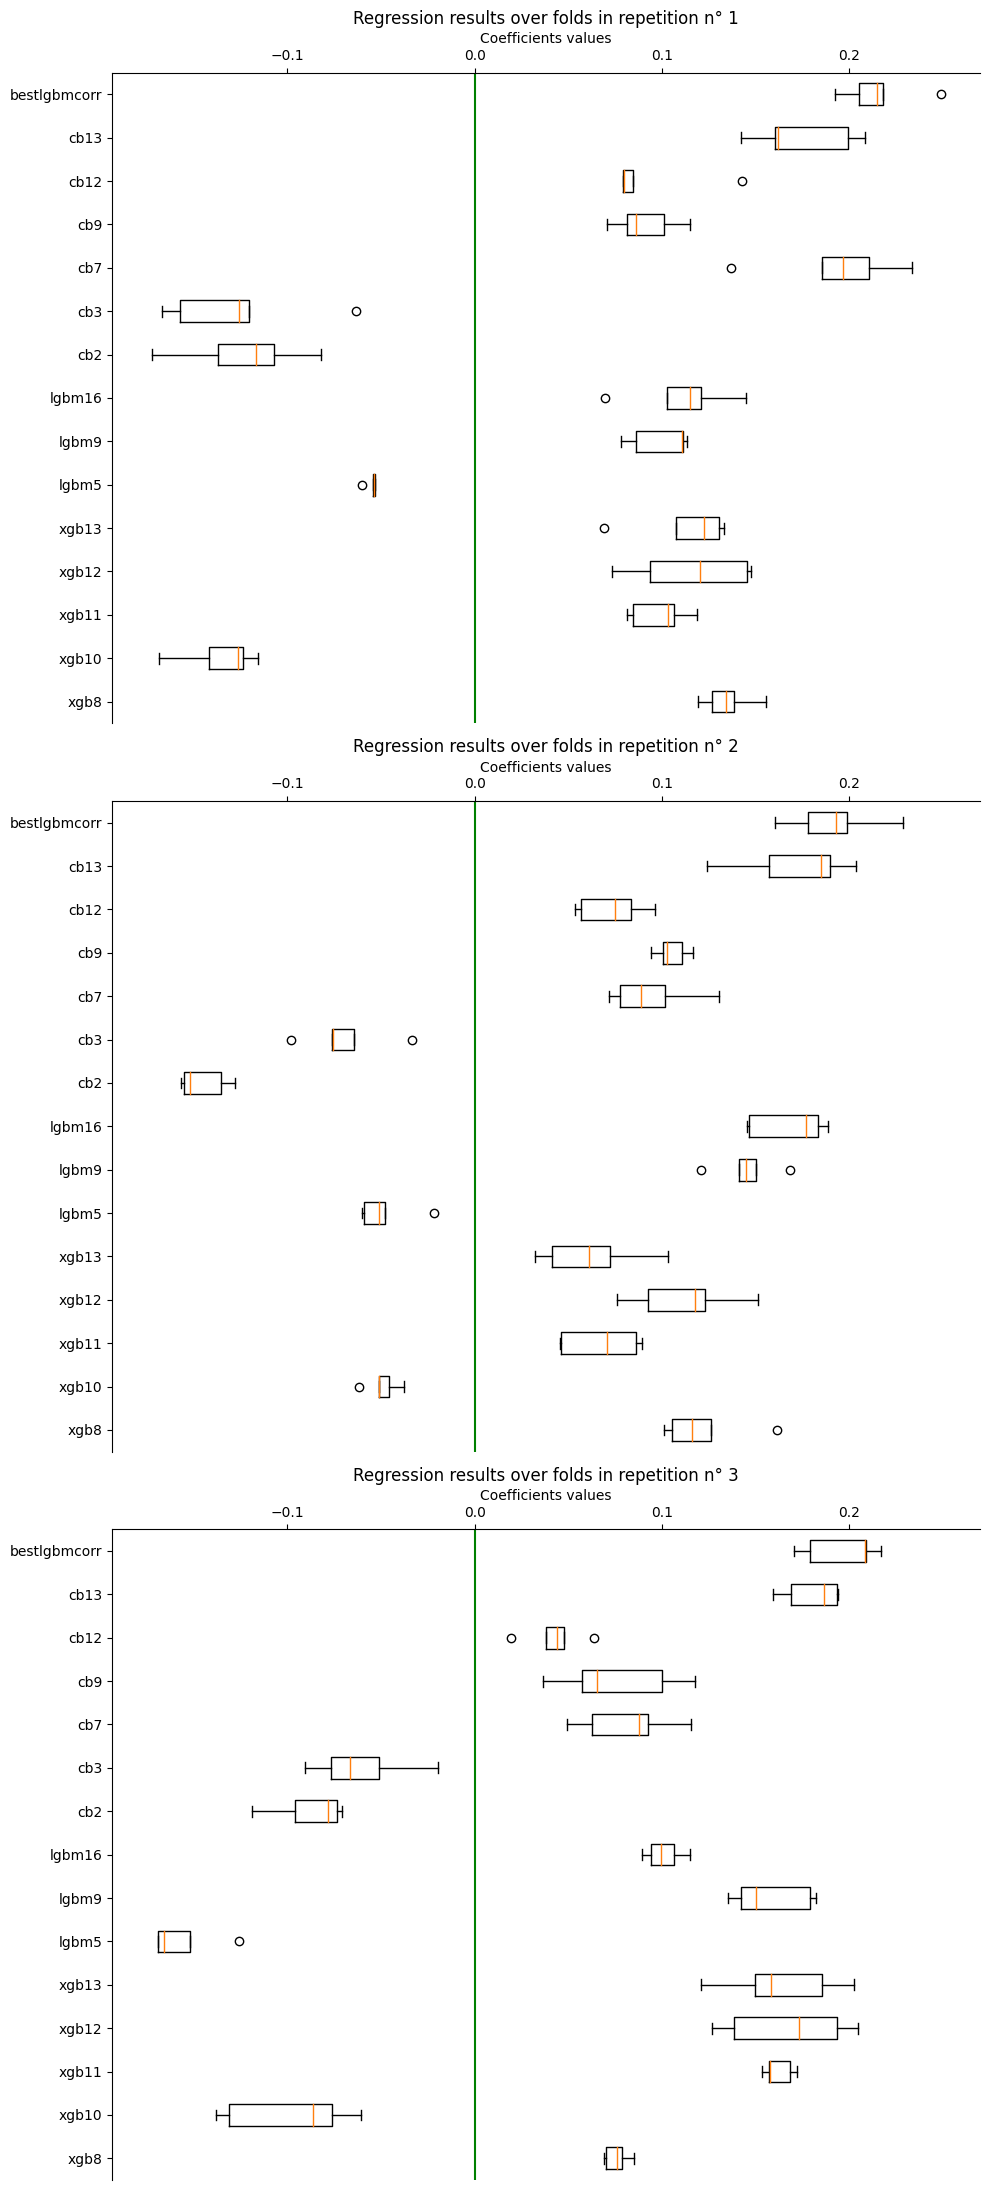

In [10]:
_, ax = plt.subplots(n_repeats, 1, figsize = (10, int(all_coefs[0].shape[1] * 0.5 * n_repeats)), 
                       sharex = True, tight_layout = True)

for i in range(n_repeats):
    ax[i].boxplot(all_coefs[i], vert = False, labels = all_coefs[i].columns)
    ax[i].axvline(x = 0, color = 'green')
    ax[i].set_title(f"Regression results over folds in repetition n° {i+1}")
    ax[i].set_xlabel("Coefficients values")
    ax[i].xaxis.set_ticks_position("top")
    ax[i].xaxis.set_label_position('top')
    ax[i].spines[["right", "bottom"]].set_visible(False)

When a coefficient is positive, it is positive in all folds. Great. All those features seems to be usefull.  
But coef for cb7, cb9, and cb12 seem to be equal. Let's try to factorize : 


    Fold  1 : R2 0.869616 (max : 0.869529 - mean : 0.869390) | in train 0.869519 | Overfitting -0.000097
    Fold  2 : R2 0.869764 (max : 0.869685 - mean : 0.869538) | in train 0.869483 | Overfitting -0.000281
    Fold  3 : R2 0.869567 (max : 0.869506 - mean : 0.869339) | in train 0.869532 | Overfitting -0.000035
    Fold  4 : R2 0.869473 (max : 0.869379 - mean : 0.869241) | in train 0.869555 | Overfitting 0.000082
    Fold  5 : R2 0.869244 (max : 0.869162 - mean : 0.869017) | in train 0.869613 | Overfitting 0.000369
  Repeat  1 : OOF R2 0.869533 | Mean R2 0.869533
OOF R2 0.869533 (max was 0.869452 - mean 0.869305) | Mean R2 : 0.869533(±0.000172)) | Overfitting : 0.000008
    Fold  1 : R2 0.869600 (max : 0.869518 - mean : 0.869386) | in train 0.869511 | Overfitting -0.000088
    Fold  2 : R2 0.869759 (max : 0.869680 - mean : 0.869550) | in train 0.869472 | Overfitting -0.000287
    Fold  3 : R2 0.869552 (max : 0.869499 - mean : 0.869333) | in train 0.869522 | Overfitting -0.000030
    

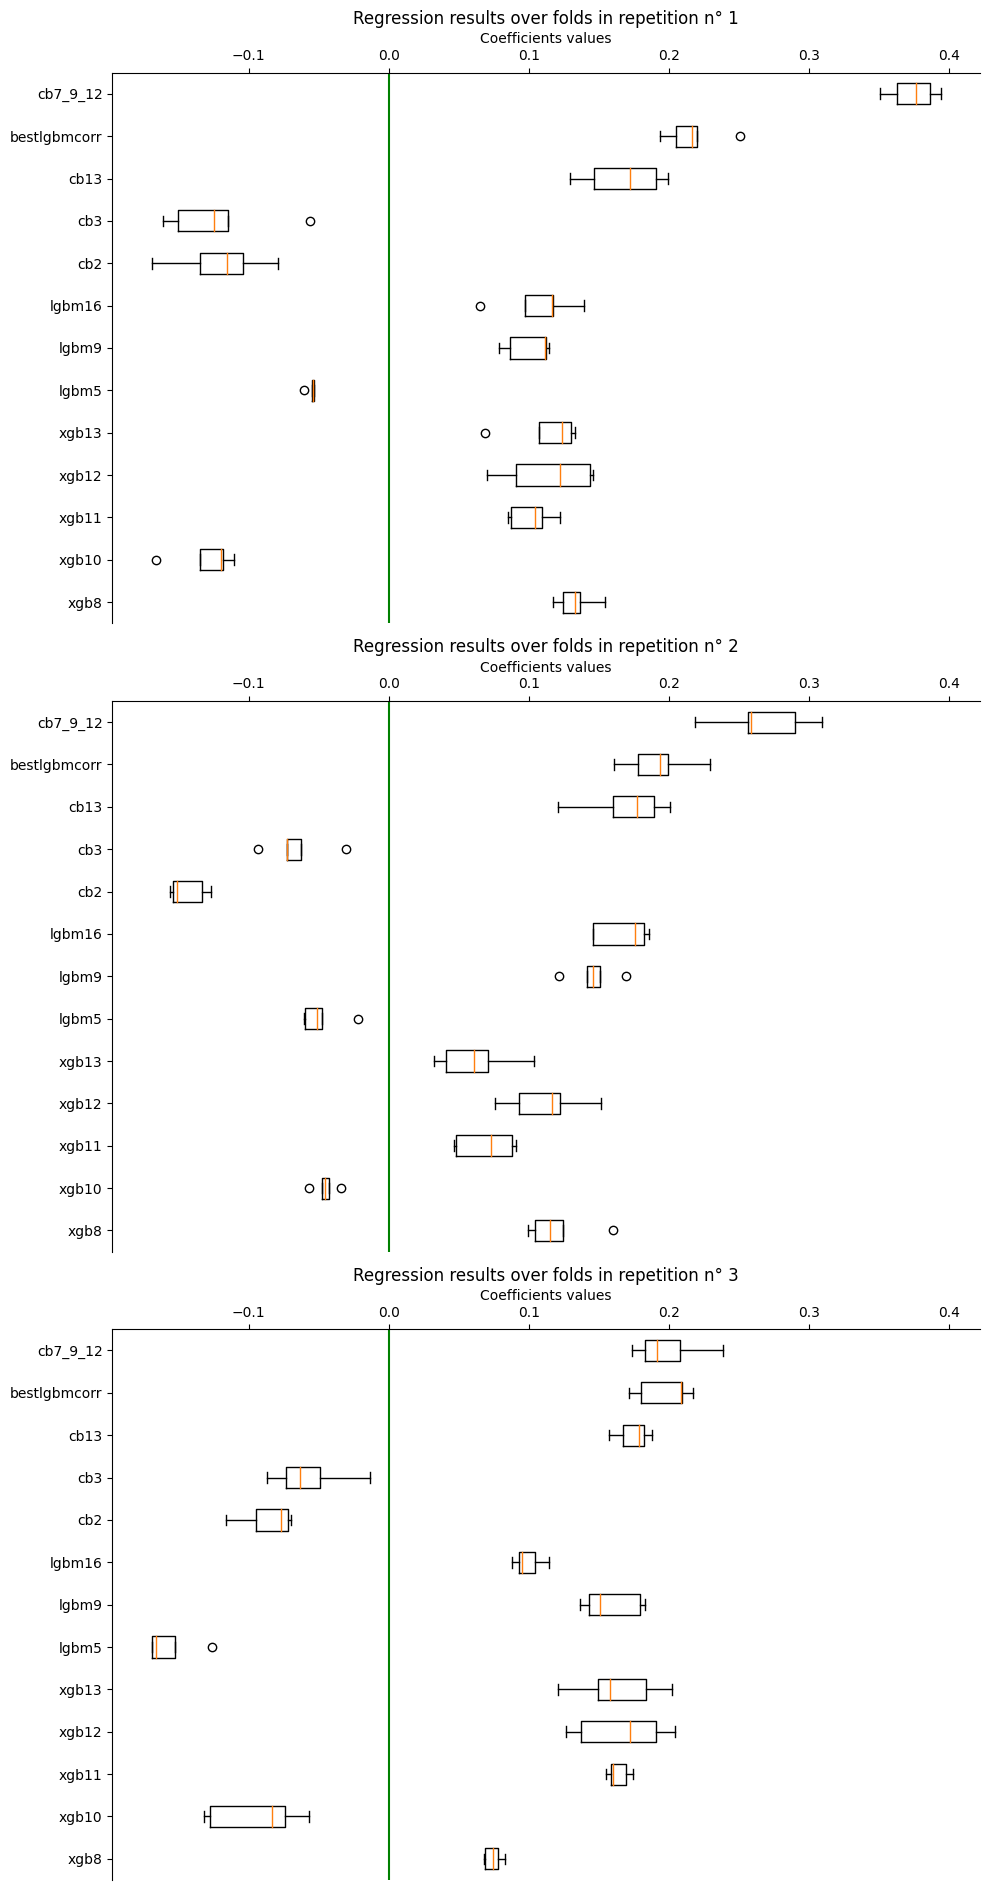

In [11]:
for n in range(n_repeats):
    for df in [oofs[n], preds[n]]:
        df["cb7_9_12"] = (df["cb7"] + df["cb9"] + df["cb12"]) / 3

for m in ["cb7_9_12"]:
    if m not in models:
        models.append(m)

final_models = [ m for m in models if m not in ["autog3", "autog5", "cb7", "cb9", "cb12"]]

params = {"alpha": .01, "random_state": seed, "fit_intercept" : False}

all_intercepts, all_coefs, blend_scores = [], [], []

for r in range(n_repeats):
    new_model = {
        "train"       : oofs[r], 
        "test"        : preds[r], 
        "features"    : final_models,
        "my_model"    : Ridge(**params), 
    }
    res = do_ensemble(**new_model, do_feat_imp = False)
    all_intercepts.extend(res["intercept"]) ; all_coefs.append(res["coefs"])
    blend_scores.append(res["oofs_score"])
    
print(f"{bold}Final mean RMSE {bold_blue}{np.mean(blend_scores):.6f}{end}")

_, ax = plt.subplots(n_repeats, 1, figsize = (10, int(all_coefs[0].shape[1] * 0.5 * n_repeats)), 
                       sharex = True, tight_layout = True)

for i in range(n_repeats):
    ax[i].boxplot(all_coefs[i], vert = False, labels = all_coefs[i].columns)
    ax[i].axvline(x = 0, color = 'green')
    ax[i].set_title(f"Regression results over folds in repetition n° {i+1}")
    ax[i].set_xlabel("Coefficients values")
    ax[i].xaxis.set_ticks_position("top")
    ax[i].xaxis.set_label_position('top')
    ax[i].spines[["right", "bottom"]].set_visible(False)

In the 3 repetition, we have .000001 or .000002 improvment by grouping those 3 features. Let's continue :
## A better ensemble

    Fold  1 : R2 0.869619 (max : 0.869570 - mean : 0.869431) | in train 0.869518 | Overfitting -0.000101
    Fold  2 : R2 0.869765 (max : 0.869693 - mean : 0.869584) | in train 0.869482 | Overfitting -0.000283
    Fold  3 : R2 0.869568 (max : 0.869520 - mean : 0.869383) | in train 0.869531 | Overfitting -0.000037
    Fold  4 : R2 0.869476 (max : 0.869382 - mean : 0.869293) | in train 0.869554 | Overfitting 0.000077
    Fold  5 : R2 0.869246 (max : 0.869165 - mean : 0.869063) | in train 0.869612 | Overfitting 0.000365
  Repeat  1 : OOF R2 0.869535 | Mean R2 0.869535
OOF R2 0.869535 (max was 0.869466 - mean 0.869351) | Mean R2 : 0.869535(±0.000172)) | Overfitting : 0.000004
    Fold  1 : R2 0.869599 (max : 0.869541 - mean : 0.869428) | in train 0.869511 | Overfitting -0.000088
    Fold  2 : R2 0.869761 (max : 0.869689 - mean : 0.869592) | in train 0.869470 | Overfitting -0.000290
    Fold  3 : R2 0.869553 (max : 0.869526 - mean : 0.869374) | in train 0.869521 | Overfitting -0.000033
    

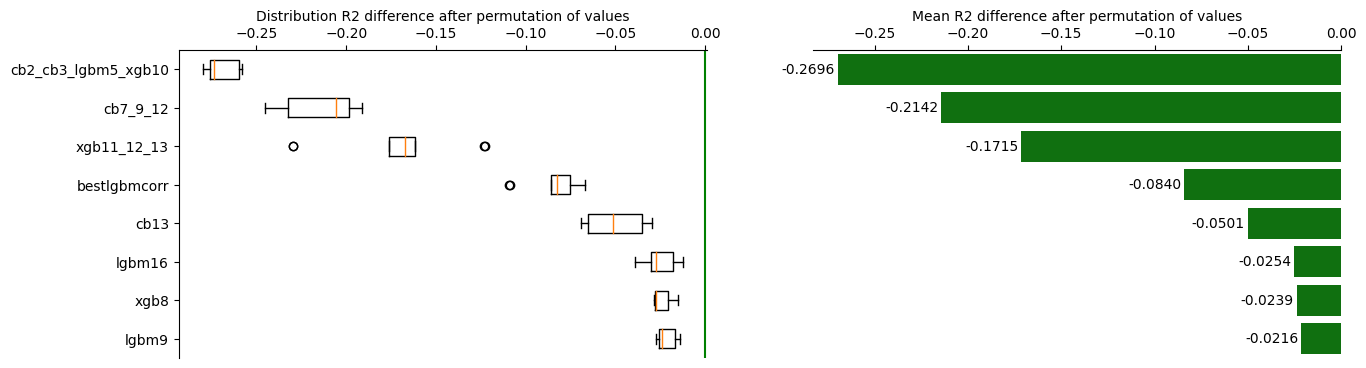

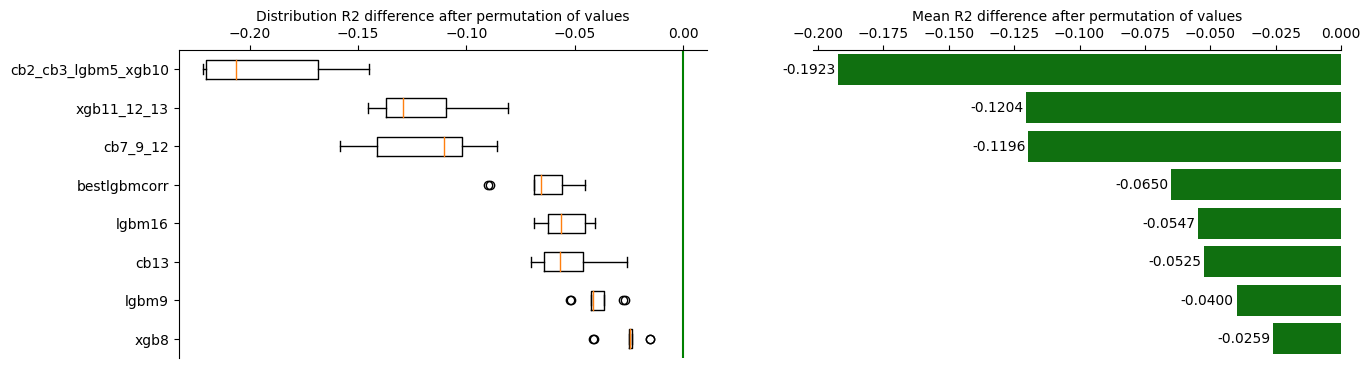

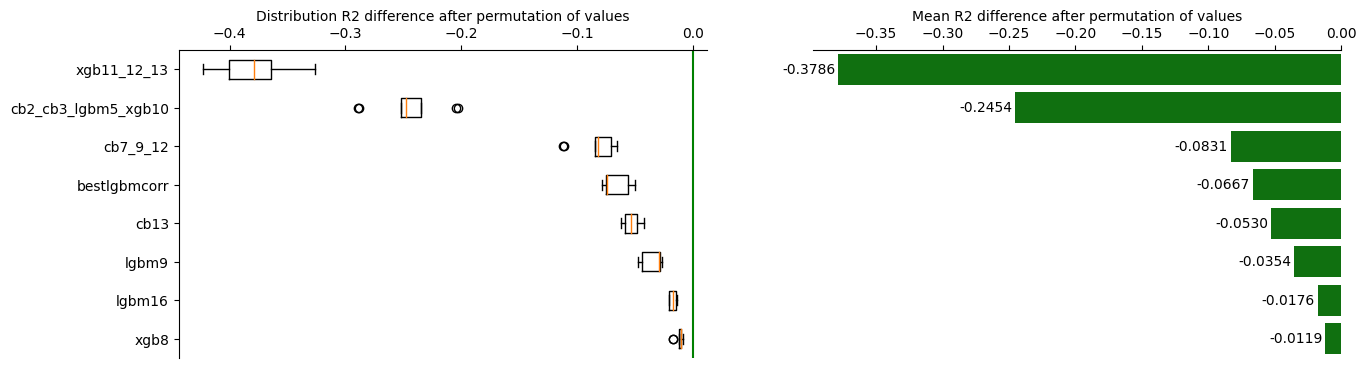

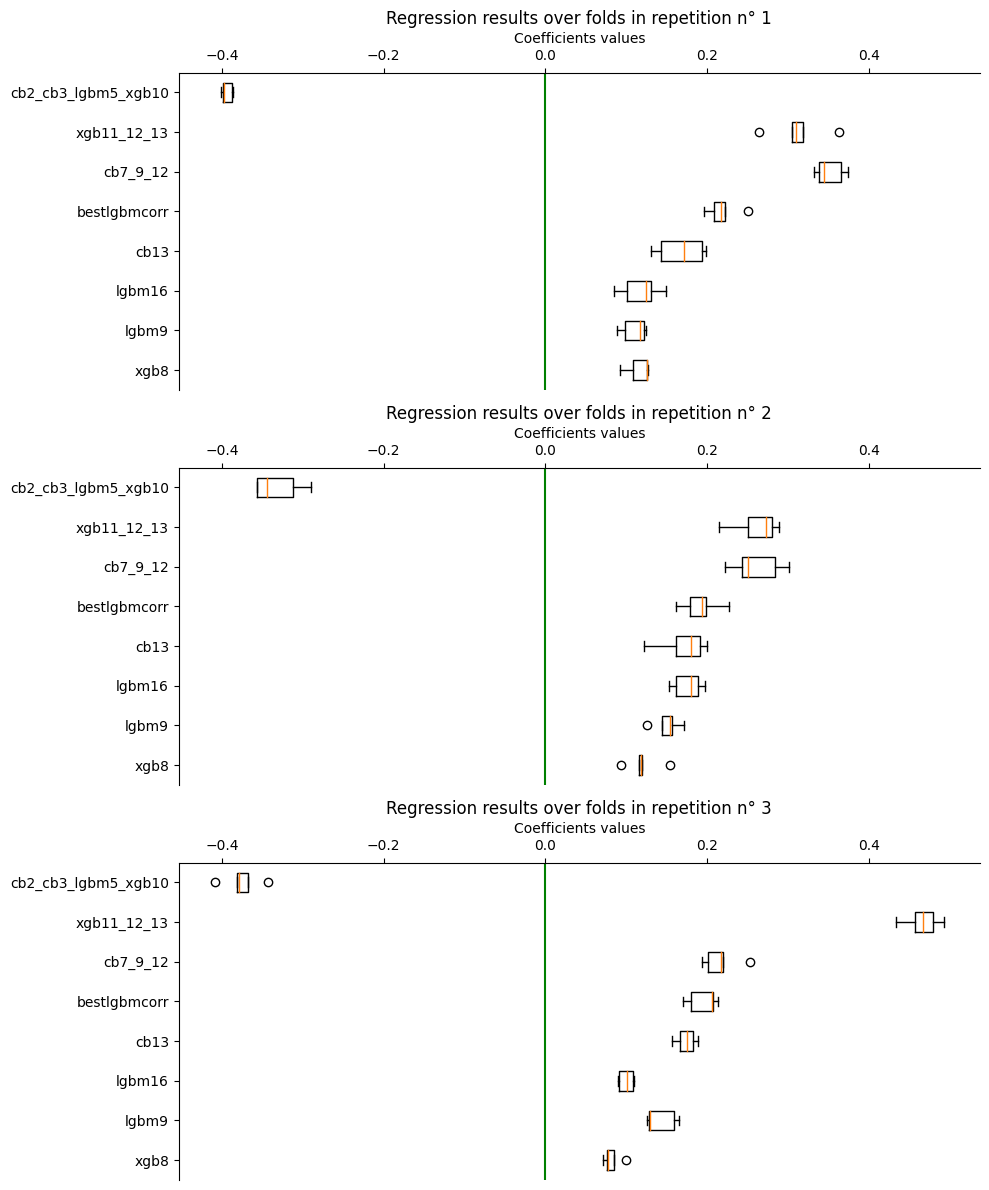

In [12]:
for n in range(n_repeats):
    for df in [oofs[n], preds[n]]:
        df["cb7_9_12"] = (df["cb7"] + df["cb9"] + df["cb12"]) / 3
        df["xgb11_12_13"] = (df["xgb11"] + df["xgb12"] + df["xgb13"]) / 3
        df["cb2_3"] = (df["cb2"] + df["cb3"]) / 2
        df["lgbm5_xgb10"] = (df["lgbm5"] + df["xgb10"]) / 2
        df["cb2_cb3_lgbm5_xgb10"] = (df["cb2"] + df["cb3"] + df["lgbm5"] + df["xgb10"]) / 4

for m in ["cb7_9_12", "xgb11_12_13", "cb2_3", "lgbm5_xgb10", "cb2_cb3_lgbm5_xgb10"]:
    if m not in models:
        models.append(m)

final_models = [ m for m in models if m not in [
    "autog3", "autog5", "xgb3", "lgbm10", "lgbm6", "lgbm14", "lgbm15", "lgbm7", "xgb9", "lgbm12",
    "cb10", "lgbm17", "rf1", "cb6", "cb11", "cb4", "cb5", "xgb6", "cb7", "cb9", "cb12",
    "xgb11", "xgb12", "xgb13", "et1", "xgb4", "lgbm11", "cb2", "cb3", "lgbm5", "xgb10",
    "bestlgbm2", "cb2_3", "lgbm5_xgb10",
]]

params = {"alpha": .01, "random_state": seed, "fit_intercept" : False}

all_intercepts, all_coefs, blend_scores = [], [], []

for r in range(n_repeats):
    new_model = {
        "train"       : oofs[r], 
        "test"        : preds[r], 
        "features"    : final_models,
        "my_model"    : Ridge(**params), 
    }
    res = do_ensemble(**new_model, do_feat_imp = True)
    all_intercepts.extend(res["intercept"]) ; all_coefs.append(res["coefs"])
    blend_scores.append(res["oofs_score"])
    
print(f"{bold}Final mean RMSE {bold_blue}{np.mean(blend_scores):.6f}{end}")

_, ax = plt.subplots(n_repeats, 1, figsize = (10, int(all_coefs[0].shape[1] * 0.5 * n_repeats)), 
                       sharex = True, tight_layout = True)

for i in range(n_repeats):
    ax[i].boxplot(all_coefs[i], vert = False, labels = all_coefs[i].columns)
    ax[i].axvline(x = 0, color = 'green')
    ax[i].set_title(f"Regression results over folds in repetition n° {i+1}")
    ax[i].set_xlabel("Coefficients values")
    ax[i].xaxis.set_ticks_position("top")
    ax[i].xaxis.set_label_position('top')
    ax[i].spines[["right", "bottom"]].set_visible(False)

So we have .000002 R2 improvment by grouping many features, and overfitting had been reduce from .000006, .000009, .0000006 to .000002, .000004, .000003.

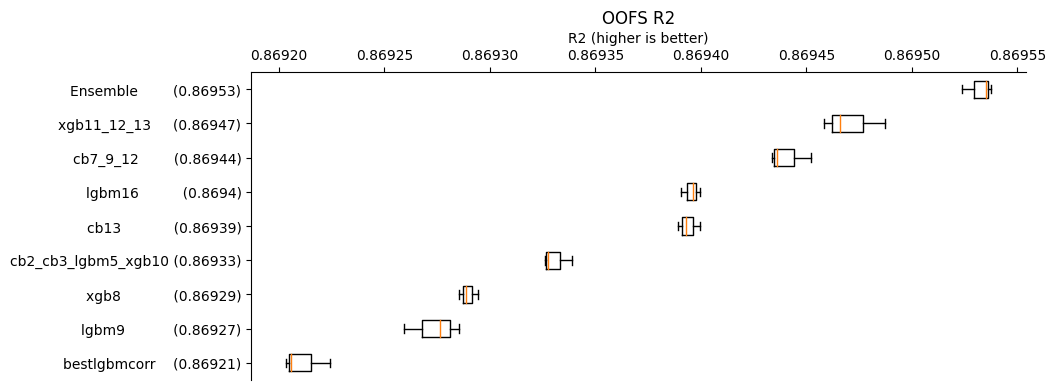

In [13]:
all_scores = {}
ascending = True
for r in range(n_repeats):
    for m in final_models:
        if r == 0:
            all_scores[m] = []
        all_scores[m].append(score_(train[target], oofs[r][m]))
        
all_scores["Ensemble"] = blend_scores

all_scores = pd.DataFrame(all_scores)
_col_order = list(all_scores.mean(axis=0).sort_values(ascending = ascending).index)
all_scores = all_scores[_col_order]

_t = list(all_scores.mean(axis=0).sort_values(ascending = ascending).values)
_labels = [f"{l:15} ({v:.5})" for l,v in zip(_col_order, _t)]

_, ax = plt.subplots(1, 1, figsize = (10, int(all_scores.shape[1] * 1/2)))
ax.boxplot(all_scores, vert = False, labels = _labels)
ax.set_title("OOFS R2")
ax.set_xlabel("R2 (higher is better)")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position('top')
ax.spines[["right", "bottom"]].set_visible(False)

['xgb8', 'lgbm9', 'lgbm16', 'cb13', 'bestlgbmcorr', 'cb7_9_12', 'xgb11_12_13', 'cb2_cb3_lgbm5_xgb10']
R2 score on train : 0.869548
id,FloodProbability
1117957,0.5788079509400098
1117958,0.4565772806163405
1117959,0.44970309662791
1117960,0.4662385715913412
1117961,0.4651132355988915
1117962,0.5077385455126949
1117963,0.5356099542926064
1117964,0.5281964412944834
1117965,0.47430288015448946


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


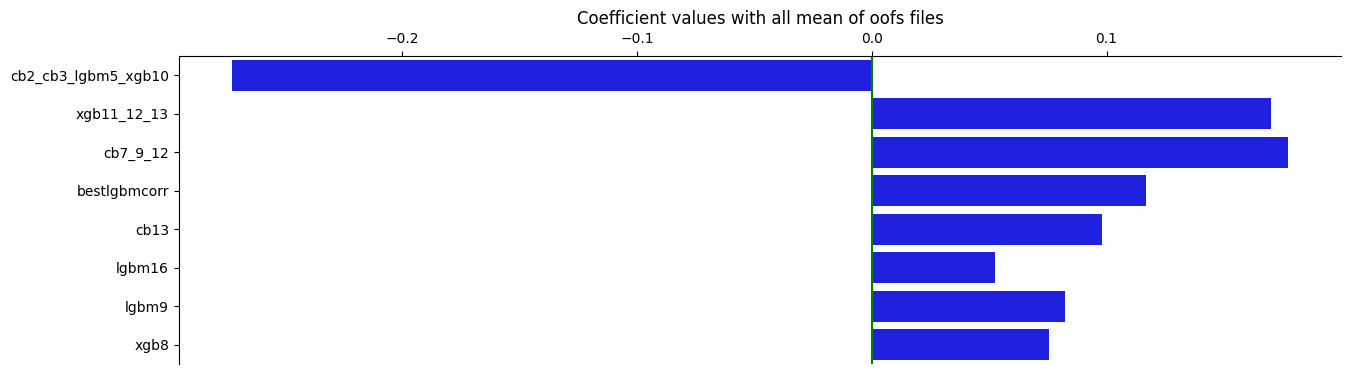

In [14]:
print(final_models)
_oofs = oofs[0][final_models].copy()
_preds = preds[0][final_models].copy()

for m in final_models:
    for n in range(n_repeats):
        _oofs[m] += oofs[n][m] / n_repeats
        _preds[m] += preds[n][m] / n_repeats
    
model = Ridge(**params)
model.fit(_oofs, train[target])
y_oof = model.predict(_oofs)
print(f"R2 score on train : {score_(train[target], y_oof):.6f}")
y_pred = pd.Series(model.predict(_preds), index=test.index, name=target)
y_pred.to_csv(f"submission_without_autogluon.csv")
!head submission_without_autogluon.csv

_, ax = plt.subplots(1, 1, figsize = (15, int(len(final_models) * 1/2)))
sns.barplot(x = model.coef_, y = final_models, ax = ax, color = "blue")
plt.gca().invert_yaxis()
ax.axvline(x = 0, color = 'green')
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position('top')
ax.spines[["right", "bottom"]].set_visible(False)
ax.set_title(f"Coefficient values with all mean of oofs files");

# Ensemble with AutoGluon predictions

    Fold  1 : R2 0.869650 (max : 0.869542 - mean : 0.869441) | in train 0.869541 | Overfitting -0.000109
    Fold  2 : R2 0.869794 (max : 0.869703 - mean : 0.869594) | in train 0.869505 | Overfitting -0.000289
    Fold  3 : R2 0.869587 (max : 0.869506 - mean : 0.869393) | in train 0.869556 | Overfitting -0.000031
    Fold  4 : R2 0.869496 (max : 0.869417 - mean : 0.869290) | in train 0.869579 | Overfitting 0.000083
    Fold  5 : R2 0.869272 (max : 0.869175 - mean : 0.869068) | in train 0.869636 | Overfitting 0.000364
  Repeat  1 : OOF R2 0.869560 | Mean R2 0.869560
OOF R2 0.869560 (max was 0.869459 - mean 0.869357) | Mean R2 : 0.869560(±0.000174)) | Overfitting : 0.000003
    Fold  1 : R2 0.869635 (max : 0.869555 - mean : 0.869439) | in train 0.869530 | Overfitting -0.000104
    Fold  2 : R2 0.869786 (max : 0.869703 - mean : 0.869600) | in train 0.869493 | Overfitting -0.000292
    Fold  3 : R2 0.869569 (max : 0.869512 - mean : 0.869375) | in train 0.869546 | Overfitting -0.000023
    

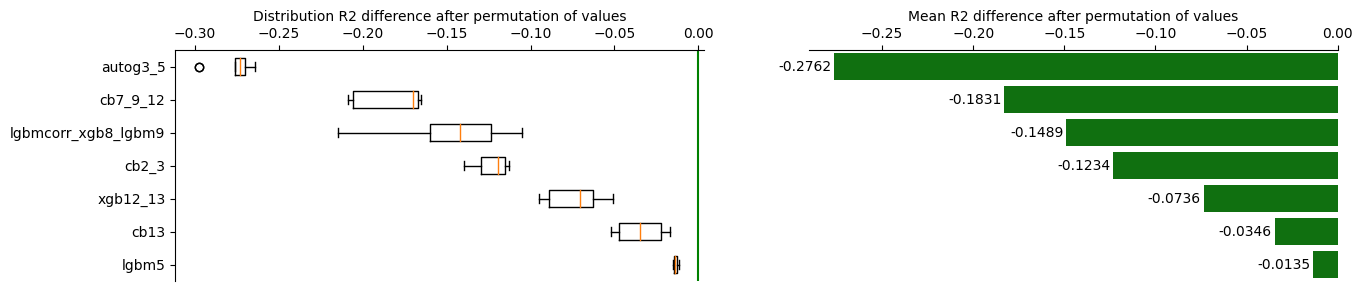

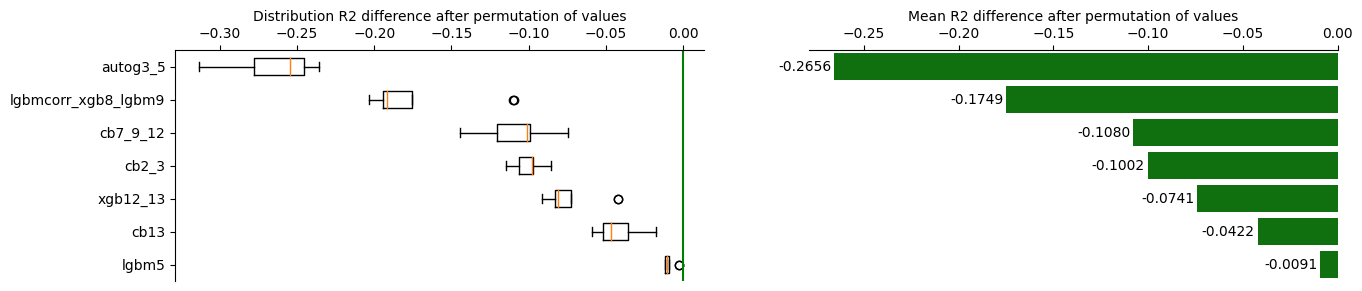

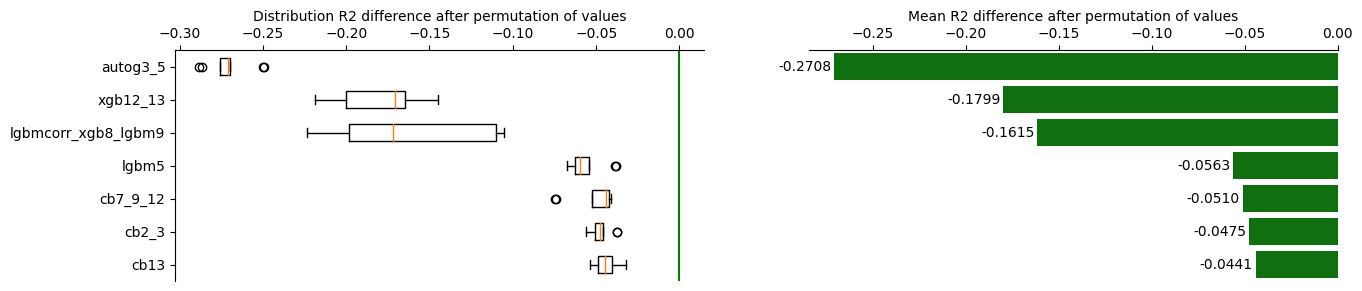

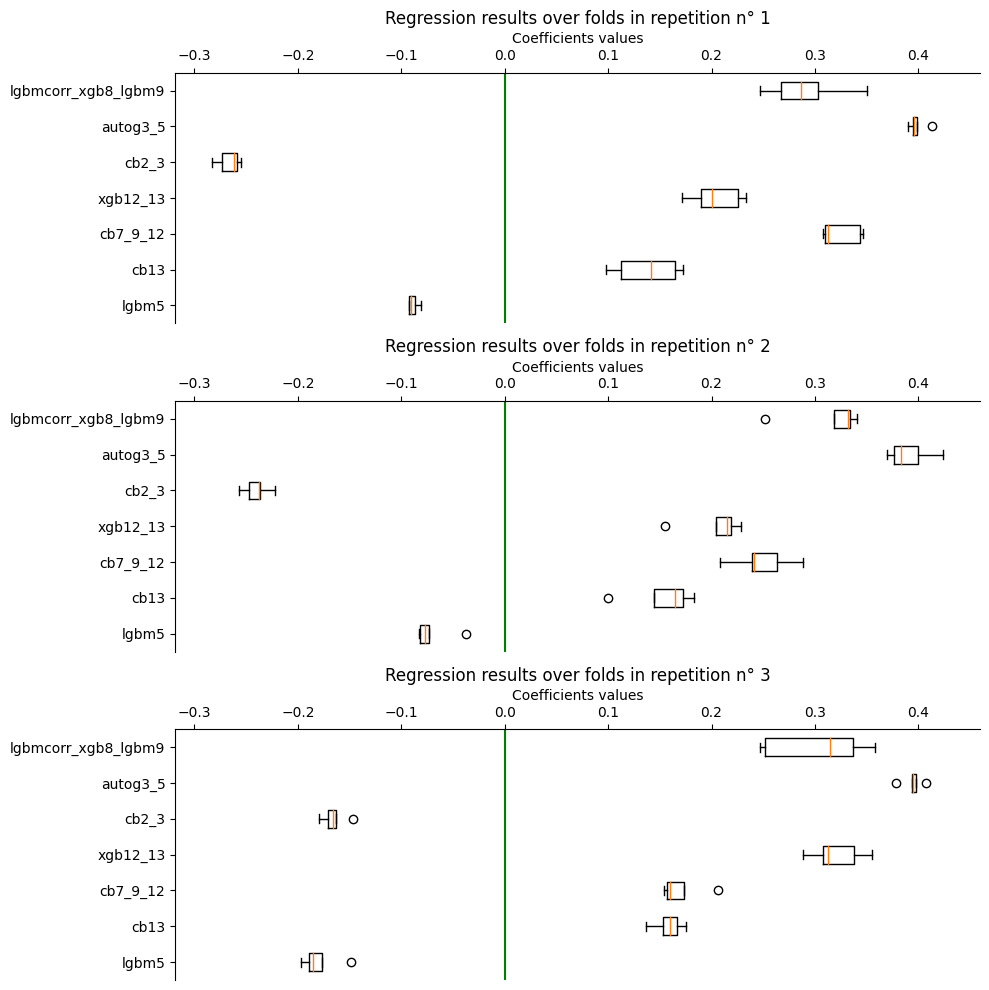

In [15]:
models = [m for m in models if m not in ["cb7_9_12", "xgb11_12_13", "cb2_3", "lgbm5_xgb10", "cb2_cb3_lgbm5_xgb10"]]

for n in range(n_repeats):
    for df in [oofs[n], preds[n]]:
        df["cb7_9_12"] = (df["cb7"] + df["cb9"] + df["cb12"]) / 3
        df["xgb12_13"] = (df["xgb12"] + df["xgb13"]) / 2
        df["autog3_5"] = (df["autog3"] + df["autog5"]) / 2
        df["cb2_3"] = (df["cb2"] + df["cb3"]) / 2
        df["lgbmcorr_xgb8_lgbm9"] = (df["bestlgbmcorr"] + df["xgb8"] + df["lgbm9"]) / 3

for m in ["cb7_9_12", "xgb12_13", "cb2_3", "autog3_5", "lgbmcorr_xgb8_lgbm9"]:
    if m not in models:
        models.append(m)

final_models = [ m for m in models if m not in 
                [
                 "lgbm12", "lgbm6", "cb4", "lgbm7", "xgb4", "cb6",
                 "cb10", "cb5", "xgb3", "xgb9", "xgb6", 
                 "xgb12", "xgb13", "rf1", "xgb10", "lgbm15", "et1", "lgbm10", # le 24 mai, avec xgb12, 13 et 12_13
                 "lgbm11", # le 25 mai avec ajout autog1
                 "cb11", "xbg11", # le 25 mai avec ajout cb12 et cb13
                 "bestlgbm2", "xgb11", "lgbm14",# le 26 mai, ajout d'un 2ème fold autogluon, et erreur sur libellé xgb11
                 
                 "cb7", "cb9", "cb12", #"cb7_9_12", 
                 "cb2", "cb3", # "cb2_3", 
                 "autog4",
                 "lgbm17", "lgbm16", # le 28 mai ajout lgbm16 et 17
#                 "autog3_5", 
                 "autog3", "autog5", 
                 "bestlgbmcorr", "xgb8", "lgbm9"
                ]]

params = {"alpha": .001, "random_state": seed, "fit_intercept" : False}#, "positive": True}
all_intercepts, all_coefs, blend_scores = [], [], []

oof_mean = pd.Series(0.0, index = train.index, name= target)

for r in range(n_repeats):
    new_model = {
        "train"       : oofs[r], 
        "test"        : preds[r], 
        "features"    : final_models,
        "my_model"    : Ridge(**params), 
    }
    res = do_ensemble(**new_model, do_feat_imp = True)
    all_intercepts.extend(res["intercept"]) ; all_coefs.append(res["coefs"])
    blend_scores.append(res["oofs_score"]) ; 
    oof_mean += res["oofs"] / n_repeats

print(f"{bold}Final mean RMSE {bold_blue}{np.mean(blend_scores):.6f}{end}")

_, ax = plt.subplots(n_repeats, 1, figsize = (10, int(all_coefs[0].shape[1] * 0.5 * n_repeats)), 
                       sharex = True, tight_layout = True)

for i in range(n_repeats):
    ax[i].boxplot(all_coefs[i], vert = False, labels = all_coefs[i].columns)
    ax[i].axvline(x = 0, color = 'green')
    ax[i].set_title(f"Regression results over folds in repetition n° {i+1}")
    ax[i].set_xlabel("Coefficients values")
    ax[i].xaxis.set_ticks_position("top")
    ax[i].xaxis.set_label_position('top')
    ax[i].spines[["right", "bottom"]].set_visible(False)

We have .000024 R2 improvemnt with autogluon  (from .86941 to .86943 on public LB)

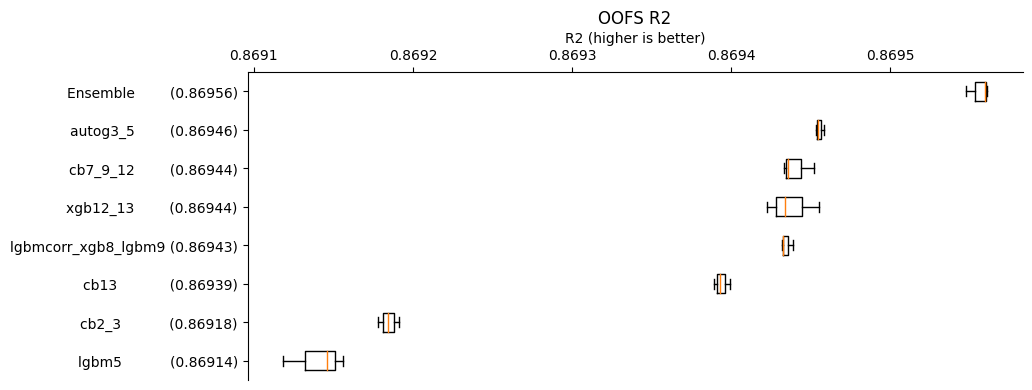

In [16]:
all_scores = {}
ascending = True
for r in range(n_repeats):
    for m in final_models:
        if r == 0:
            all_scores[m] = []
        all_scores[m].append(score_(train[target], oofs[r][m]))
        
all_scores["Ensemble"] = blend_scores

all_scores = pd.DataFrame(all_scores)
_col_order = list(all_scores.mean(axis=0).sort_values(ascending = ascending).index)
all_scores = all_scores[_col_order]

_t = list(all_scores.mean(axis=0).sort_values(ascending = ascending).values)
_labels = [f"{l:15} ({v:.5})" for l,v in zip(_col_order, _t)]

_, ax = plt.subplots(1, 1, figsize = (10, int(all_scores.shape[1] * 1/2)))
ax.boxplot(all_scores, vert = False, labels = _labels)
ax.set_title("OOFS R2")
ax.set_xlabel("R2 (higher is better)")
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position('top')
ax.spines[["right", "bottom"]].set_visible(False)

['lgbm5', 'cb13', 'cb7_9_12', 'xgb12_13', 'cb2_3', 'autog3_5', 'lgbmcorr_xgb8_lgbm9']
R2 score on train : 0.869571
id,FloodProbability
1117957,0.5789696708652685
1117958,0.45601814813451247
1117959,0.44925924781606047
1117960,0.4663307019370348
1117961,0.4654664269075982
1117962,0.5076945949617011
1117963,0.5355699871003303
1117964,0.5283211768435949
1117965,0.4743431790048298


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


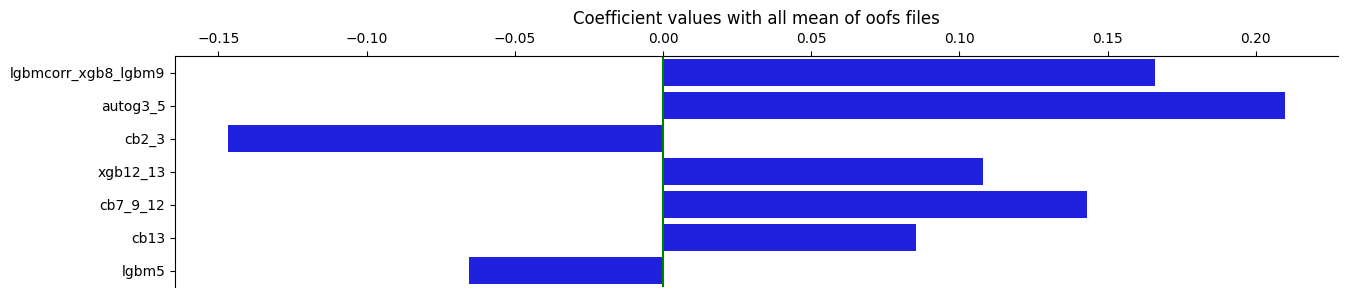

In [17]:
print(final_models)
_oofs = oofs[0][final_models].copy()
_preds = preds[0][final_models].copy()

for m in final_models:
    for n in range(n_repeats):
        _oofs[m] += oofs[n][m] / n_repeats
        _preds[m] += preds[n][m] / n_repeats
    
model = Ridge(**params)
model.fit(_oofs, train[target])
y_oof = model.predict(_oofs)
print(f"R2 score on train : {score_(train[target], y_oof):.6f}")
y_pred = pd.Series(model.predict(_preds), index = test.index, name = target)
y_pred.to_csv(f"submission_with_autogluon.csv")
!head submission_with_autogluon.csv

_, ax = plt.subplots(1, 1, figsize = (15, int(len(final_models) * 1/2)))
sns.barplot(x = model.coef_, y = final_models, ax = ax, color = "blue")
plt.gca().invert_yaxis()
ax.axvline(x = 0, color = 'green')
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position('top')
ax.spines[["right", "bottom"]].set_visible(False)
ax.set_title(f"Coefficient values with all mean of oofs files");

# Test "mean of oof" vs "oof of mean"
We will see there no significant difference
## Mean of oofs
We knew the mean of 3 oofs score

In [18]:
folds = StratifiedKFold(n_splits = n_splits, random_state = seed, shuffle = True)
for fold, (_, val_idx) in enumerate(folds.split(train, (train[target]*400).astype(np.int16).astype("category"))):
    print(f"   Fold {fold+1} : R2 {score_(train.loc[val_idx, target], oof_mean.loc[val_idx]):.6f}")    

print(f"Mean of oof R2 score : {score_(train[target], oof_mean):.6f}")

   Fold 1 : R2 0.869650
   Fold 2 : R2 0.869808
   Fold 3 : R2 0.869600
   Fold 4 : R2 0.869514
   Fold 5 : R2 0.869278
Mean of oof R2 score : 0.869570


## R2 score on prediction mean of oofs

    Fold  1 : R2 0.869651 (max : 0.869571 - mean : 0.869473) | in train 0.869553 | Overfitting -0.000098
    Fold  2 : R2 0.869804 (max : 0.869728 - mean : 0.869637) | in train 0.869515 | Overfitting -0.000289
    Fold  3 : R2 0.869597 (max : 0.869550 - mean : 0.869427) | in train 0.869566 | Overfitting -0.000032
    Fold  4 : R2 0.869514 (max : 0.869434 - mean : 0.869329) | in train 0.869587 | Overfitting 0.000072
    Fold  5 : R2 0.869279 (max : 0.869202 - mean : 0.869103) | in train 0.869646 | Overfitting 0.000367
  Repeat  1 : OOF R2 0.869569 | Mean R2 0.869569
OOF R2 0.869569 (max was 0.869482 - mean 0.869394) | Mean R2 : 0.869569(±0.000173)) | Overfitting : 0.000004


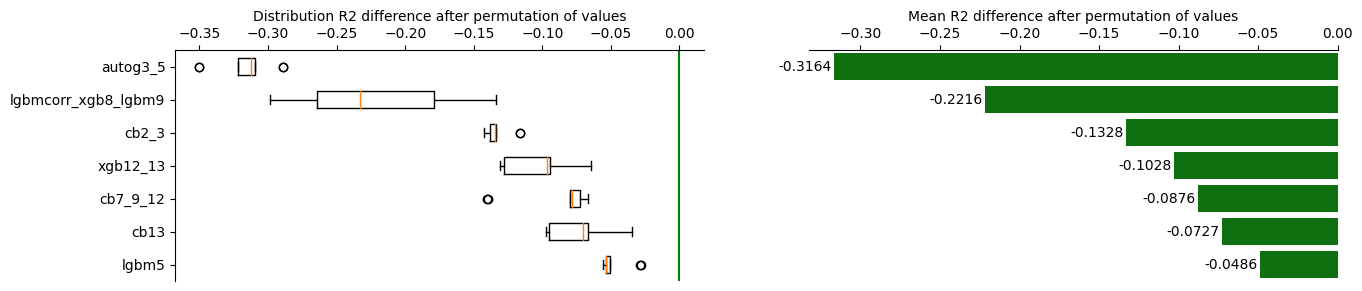

In [19]:
oofs_other = pd.DataFrame(index = train.index)
for m in final_models:
    oofs_other[f"{m}"] = 0 
    for r in range(n_repeats):
        oofs_other[f"{m}"] += oofs[r][m] / n_repeats
    
oofs_other[target] = train[target]

new_model = {
    "train"       : oofs_other, 
    "test"        : preds[0], 
    "features"    : final_models,
    "my_model"    : Ridge(**params), 
}
_ = do_ensemble(**new_model, do_feat_imp = True)

# Test : add more predictions

    Fold  1 : R2 0.869396 (max : 0.869332 - mean : 0.869210) | in train 0.869604 | Overfitting 0.000207
    Fold  2 : R2 0.869996 (max : 0.869882 - mean : 0.869786) | in train 0.869454 | Overfitting -0.000542
    Fold  3 : R2 0.868916 (max : 0.868822 - mean : 0.868697) | in train 0.869724 | Overfitting 0.000808
    Fold  4 : R2 0.870001 (max : 0.869924 - mean : 0.869807) | in train 0.869453 | Overfitting -0.000548
    Fold  5 : R2 0.869492 (max : 0.869388 - mean : 0.869286) | in train 0.869581 | Overfitting 0.000089
  Repeat  1 : OOF R2 0.869560 | Mean R2 0.869560
OOF R2 0.869560 (max was 0.869459 - mean 0.869357) | Mean R2 : 0.869560(±0.000408)) | Overfitting : 0.000003
    Fold  1 : R2 0.869404 (max : 0.869312 - mean : 0.869207) | in train 0.869588 | Overfitting 0.000184
    Fold  2 : R2 0.869989 (max : 0.869888 - mean : 0.869789) | in train 0.869442 | Overfitting -0.000546
    Fold  3 : R2 0.868897 (max : 0.868824 - mean : 0.868690) | in train 0.869715 | Overfitting 0.000818
    Fol

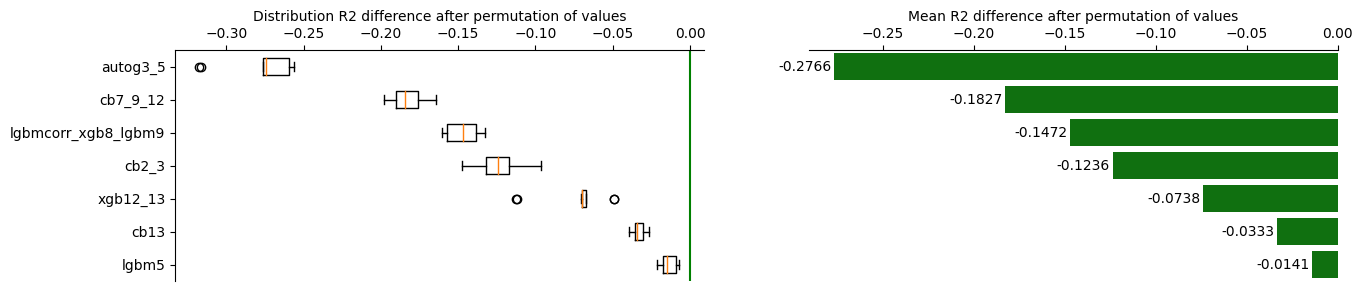

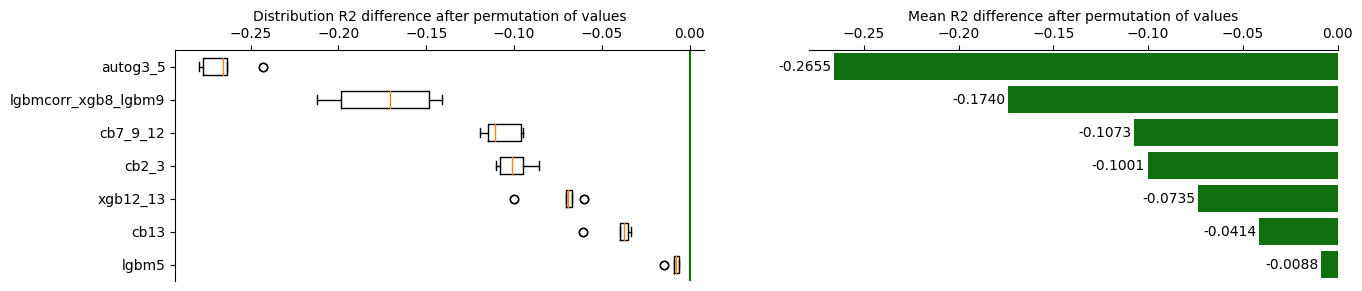

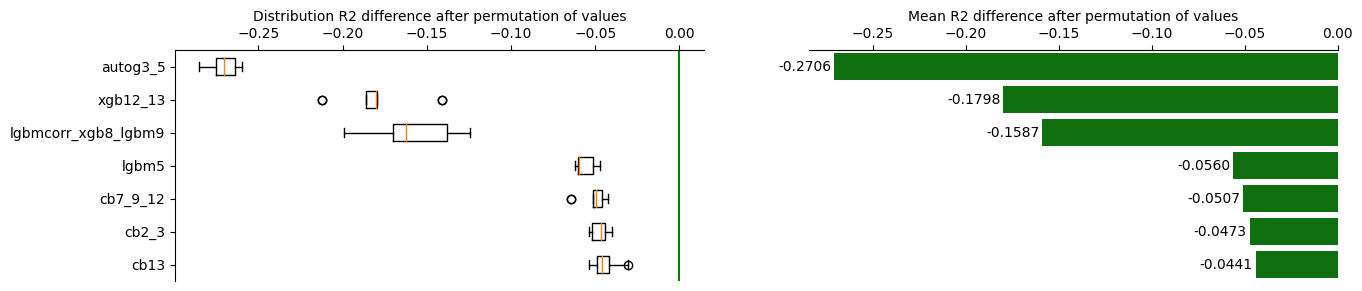

In [20]:
blend_scores = []
oof_mean2 = pd.Series(0.0, index = train.index, name= target)
for r in range(n_repeats):
    new_model = {
        "train"       : oofs[r], 
        "test"        : preds[r], 
        "features"    : final_models,
        "my_model"    : Ridge(**params), 
        "folds"       : StratifiedKFold(n_splits = n_splits, random_state = seed + 10, shuffle = True), 
    }
    res = do_ensemble(**new_model, do_feat_imp = True)
    all_intercepts.extend(res["intercept"]) ; all_coefs.append(res["coefs"])
    blend_scores.append(res["oofs_score"]) ; 
    oof_mean2 += res["oofs"] / n_repeats
    
print(f"{bold}Final mean RMSE {bold_blue}{np.mean(blend_scores):.6f}{end}")
print(f"R2 score oof_mean {score_(train[target], oof_mean):.6f} | oof_mean2 {score_(train[target], oof_mean2):.6f} | ", end='')
print(f"oof_mean + oof_mean2 : {score_(train[target], .5 * (oof_mean + oof_mean2)):.6f}")